In [10]:
import torch
import matplotlib.pyplot as plt

In [1]:
import torchmetrics

In [2]:
cm = torchmetrics.ConfusionMatrix('multiclass', num_classes=8)

In [8]:
y = torch.randint(0, 7, (4, 4))

In [9]:
yhat = torch.randint(0, 7, (4, 4))

In [43]:
y

tensor([[5, 5, 3, 5],
        [5, 2, 2, 1],
        [0, 1, 3, 6],
        [2, 4, 3, 1]])

In [44]:
yhat

tensor([[0, 2, 1, 1],
        [2, 3, 4, 6],
        [0, 5, 2, 2],
        [6, 1, 5, 3]])

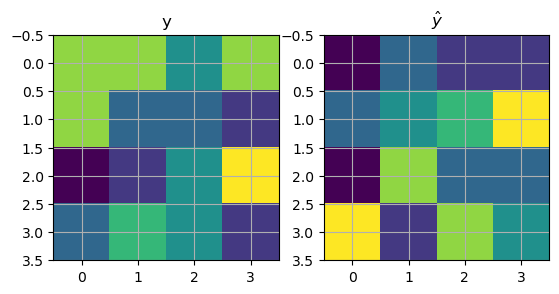

In [42]:
fig, axes = plt.subplots(1, 2)
axes[0].set_title("y")
axes[0].imshow(y.detach())
axes[1].set_title("$\hat{y}$")
axes[1].imshow(yhat.detach())
axes[0].grid(True)
axes[1].grid(True)

In [21]:
min_length = 8**2

In [28]:
yflat = y.flatten()
yhatflat = yhat.flatten()

In [29]:
mapping = yflat.to(torch.long) * 8 + yhatflat.to(torch.long)


In [30]:
bins = torch.bincount(mapping, minlength=min_length)

In [31]:
bins

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0,
        0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 2, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [33]:
viewBins = bins.reshape(8,8)

Text(0.5, 0, 'prediction')

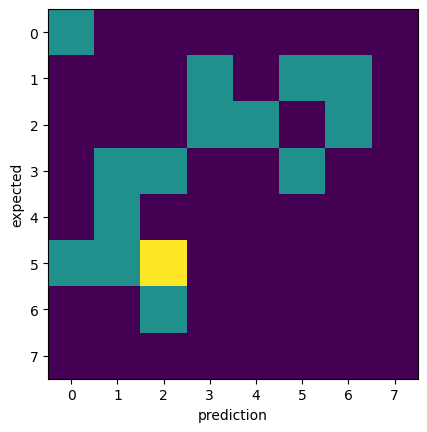

In [45]:
plt.imshow(viewBins.detach())
plt.ylabel("expected")
plt.xlabel("prediction")

In [46]:
num = torch.diag(viewBins)
denom = viewBins.sum(0) + viewBins.sum(1) - num

In [47]:
num

tensor([1, 0, 0, 0, 0, 0, 0, 0])

In [48]:
denom

tensor([2, 6, 7, 5, 2, 6, 3, 0])

In [50]:
def _safe_divide(num: torch.Tensor, denom: torch.Tensor) -> torch.Tensor:
    """Safe division, by preventing division by zero.

    Additionally casts to float if input is not already to secure backwards compatibility.
    """
    denom[denom == 0.0] = 1
    num = num if num.is_floating_point() else num.float()
    denom = denom if denom.is_floating_point() else denom.float()
    return num / denom

In [49]:
num = num.sum()
denom = denom.sum()

In [52]:
jaccard = _safe_divide(num, denom)

In [53]:
jaccard

tensor(0.0323)

In [ ]:
from torch import nn
from typing import Optional

def _bincount(x: torch.Tensor, minlength: Optional[int] = None) -> torch.Tensor:
    """Implement custom bincount.

    PyTorch currently does not support ``torch.bincount`` for:

        - deterministic mode on GPU.
        - MPS devices

    This implementation fallback to a for-loop counting occurrences in that case.

    Args:
        x: tensor to count
        minlength: minimum length to count

    Returns:
        Number of occurrences for each unique element in x

    Example:
        >>> x = torch.tensor([0,0,0,1,1,2,2,2,2])
        >>> _bincount(x, minlength=3)
        tensor([3, 2, 4])

    """
    if minlength is None:
        minlength = len(torch.unique(x))
    if torch.are_deterministic_algorithms_enabled() or _XLA_AVAILABLE or _TORCH_GREATER_EQUAL_1_12 and x.is_mps:
        output = torch.zeros(minlength, device=x.device, dtype=torch.long)
        for i in range(minlength):
            output[i] = (x == i).sum()
        return output
    return torch.bincount(x, minlength=minlength)

class IoULoss(nn.Module):
    num_classes: int

    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.min_length = num_classes**2
        
    def cuda_bins():


    def forward(self, predicted, expected):
        p, e = predicted.flatten(), expected.flatten()
        unique_mapping = e.to(torch.long) * 8 + p.to(torch.long)
        